In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import ast
import time
import sys, os

from src.data_loading import load_data

# Load the network

In [2]:
G = load_data()

Graph loaded: 4941 nodes, 6594 edges


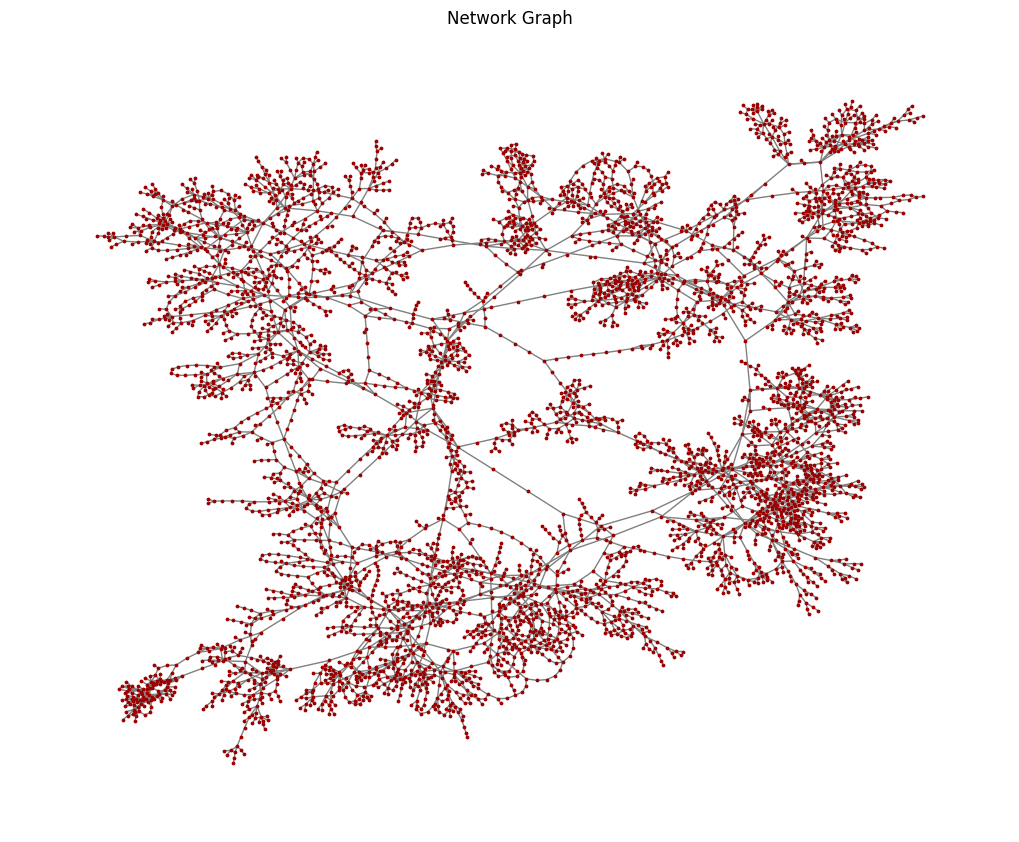

In [10]:
# Draw the graph
def draw_graph(G):
    plt.figure(figsize=(10, 8))

    pos = nx.get_node_attributes(G, "pos")

    nx.draw(
        G,
        pos,
        node_color="#9c0101",
        node_size=3,
        edge_color="grey",
    )

    plt.title("Network Graph")
    plt.show()

draw_graph(G)

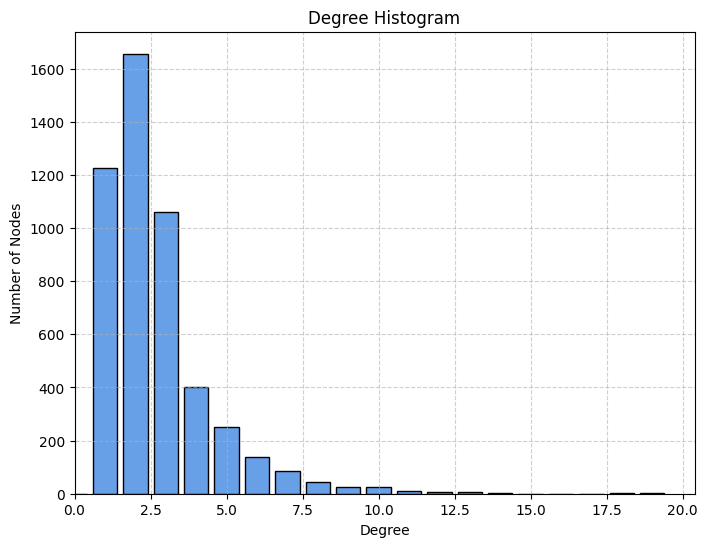

In [11]:
# Degree histogram
degree_hist = nx.degree_histogram(G)
degrees = range(len(degree_hist))
counts = degree_hist

plt.figure(figsize=(8, 6))
plt.bar(degrees, counts, width=0.80, color='#68a0e8', edgecolor='black')

plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.show()

In [12]:
def cascade_failure(graph, initial_failed_edges, threshold=0.5, max_seconds=300):
    import time, random
    start_time = time.time()
    G = graph.copy()
    failed_edges = list(initial_failed_edges)
    all_failed_edges = set(tuple(sorted(e)) for e in failed_edges)

    for e in failed_edges:
        if G.has_edge(*e):
            G.remove_edge(*e)

    while failed_edges and (time.time() - start_time) < max_seconds:
        new_failures = []
        for u, v in failed_edges:
            for node in (u, v):
                for neighbor in list(G.neighbors(node)):
                    candidate_edge = tuple(sorted((node, neighbor)))
                    if candidate_edge not in all_failed_edges and G.has_edge(*candidate_edge):
                        if random.random() < threshold:
                            new_failures.append(candidate_edge)
                            all_failed_edges.add(candidate_edge)
                            G.remove_edge(*candidate_edge)
        failed_edges = new_failures

    return G, all_failed_edges


In [13]:
def draw_graph_after_failure(G_before, failed_edges):
    pos = nx.get_node_attributes(G_before, "pos")

    plt.figure(figsize=(10, 8))

    intact_edges = [e for e in G_before.edges() if e not in failed_edges and (e[1], e[0]) not in failed_edges]
    nx.draw_networkx_edges(G_before, pos, edgelist=intact_edges, edge_color='grey', alpha=0.7)

    nx.draw_networkx_edges(G_before, pos, edgelist=failed_edges, edge_color='red', alpha=0.9)

    failed_nodes = set()
    for u, v in failed_edges:
        failed_nodes.add(u)
        failed_nodes.add(v)
    node_colors = ["#9c0101" if n in failed_nodes else "#50bee6" for n in G_before.nodes()]
    nx.draw_networkx_nodes(G_before, pos, node_color=node_colors, node_size=3)

    plt.title("Network Graph After Cascade Failure")
    plt.axis('off')
    plt.show()

After attack: 4941 nodes, 6593 edges


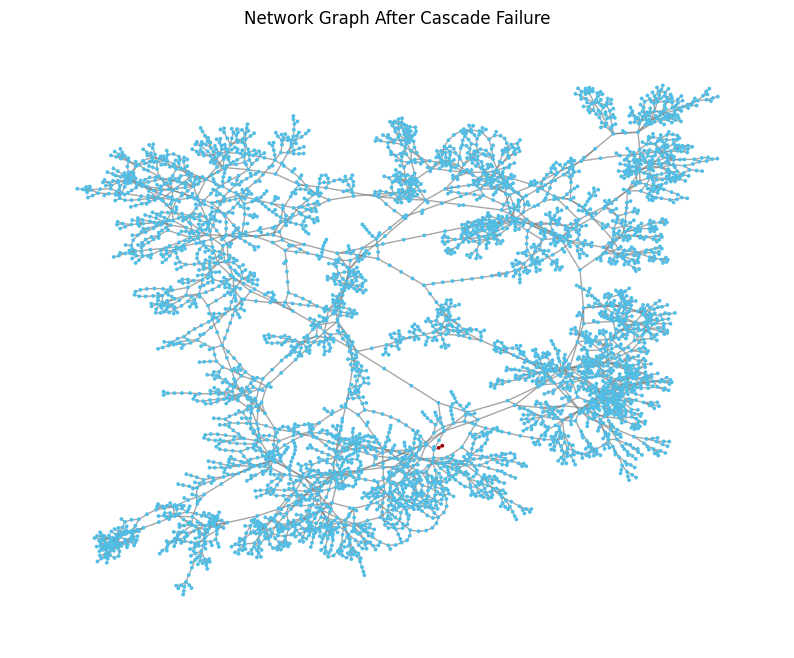

In [20]:
# Random edge attack
edges_list = list(G.edges())
random_edge = random.choice(edges_list)
initial_failed_edges = []
initial_failed_edges.append(random_edge)
G_after_attack, failed_edges = cascade_failure(graph=G, initial_failed_edges=initial_failed_edges, threshold=0.3)
print(f"After attack: {G_after_attack.number_of_nodes()} nodes, {G_after_attack.number_of_edges()} edges")

draw_graph_after_failure(G_before=G, failed_edges=failed_edges)

After attack: 4941 nodes, 6580 edges


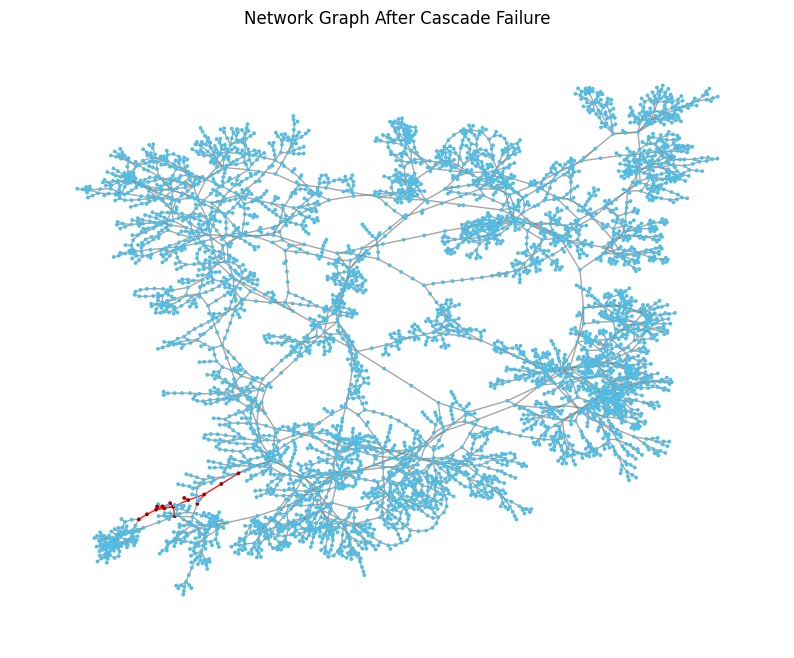

In [16]:
# Random node attack
nodes_list = list(G.nodes())
random_node = random.choice(nodes_list)
incident_edges = list(G.edges(random_node))
initial_edges = []
initial_edges.extend(incident_edges)
G_after_attack, failed_edges = cascade_failure(graph=G, initial_failed_edges=initial_edges, threshold=0.2)
print(f"After attack: {G_after_attack.number_of_nodes()} nodes, {G_after_attack.number_of_edges()} edges")

draw_graph_after_failure(G_before=G, failed_edges=failed_edges)